# Projeto 3#
#### Antonio Fonseca, Daniel Pucciariello e José Bechara.####

## Tema:##
*Prever se um projeto do kickstarter irá ser bem sucedido ou não.*

Técnica: Classificador.

https://www.kaggle.com/kemical/kickstarter-projects


In [1]:
%matplotlib notebook
%reset -f


import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from datetime import datetime

%matplotlib inline

In [2]:
def dummify(data, column_name):
    """
        Converte a coluna column_name em dummies / one-hot e as adiciona ao dataframe
        retorna uma copia do  df original *sem* a coluna que foi dummified
    """
    df = data.copy()
    # Nota: se você for um econometrista, pode se interessar por usar a opção dropFirst = True na get_dummies
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

def calculo_dias(date1,date2):
    date_format = "%Y-%m-%d %H:%M:%S"
    a = datetime.strptime(date1, date_format)
    b = datetime.strptime(date2, date_format)
    delta= a-b
    return delta.days

## Leitura dos dataframes:

In [3]:
data = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
data1 = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])

In [4]:
data = data[data.state != "live"]# ARRUMAR ISSO
# data_live=data1.query('state == "live"')

data_boolean = data.replace("canceled", "failed").replace("undefined", "failed").replace("suspended", "failed")

In [5]:
data.main_category.value_counts()

Film & Video    63253
Music           51637
Publishing      39575
Games           34944
Technology      32192
Design          29765
Art             27959
Food            24418
Fashion         22566
Theater         10872
Comics          10743
Photography     10731
Crafts           8733
Journalism       4724
Dance            3750
Name: main_category, dtype: int64

### Dataframe cru:

In [6]:
data.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


### Categorias:

In [7]:
data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [8]:
data.category = data.category.astype('category')
data.main_category = data.main_category.astype('category')
data.state = data.state.astype('category')
data.country = data.country.astype('category')

### Porcentagem de sucesso nos projetos:

In [9]:
failed=data_boolean.state.value_counts()[0]
sucessful=data_boolean.state.value_counts()[1]
print("Número de projetos que falharam:", failed)
print("Número de projetos bem sucedidos:", sucessful)
print("Porcentagem de sucesso:", 100*sucessful/(failed + sucessful), "%")

Número de projetos que falharam: 241906
Número de projetos bem sucedidos: 133956
Porcentagem de sucesso: 35.639676264160784 %


### Representação gráfica desses dados:

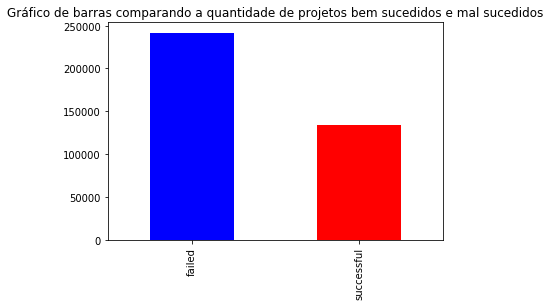

In [10]:
data_boolean.state.value_counts().plot(kind='bar', color=('blue', 'red'), legend=False)
plt.title("Gráfico de barras comparando a quantidade de projetos bem sucedidos e mal sucedidos")
plt.show();

### "Dummyficando" as variáveis qualitativas:

In [11]:
data_dummified = dummify(data, "main_category")
data_dummified = dummify(data_dummified, "state")

data_dummified.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'state_canceled', 'state_failed',
       'state_successful', 'state_suspended', 'state_undefined'],
      dtype='object')

In [12]:
#quantitativas = data_dummified.loc[:,['goal', 'pledged', 'launched']
quantitativas = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater' ]]
quantitativas.head(5)

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Calculando o tempo de duração da campanha:

In [13]:
delta_t =[]
for e,i in zip(data.deadline, data.launched):
    e = str(e)
    i = str(i)
    a = calculo_dias(e,i)
    delta_t.append(a)

In [14]:
data_delta_t=quantitativas
data_delta_t["deltat (days)"]=delta_t
data_delta_t.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,deltat (days)
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,58
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,59
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,44
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,29
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,55


In [15]:
y = quantitativas.state_successful == 1 # Selecionando apenas as campanhas que obtiveram sucesso

# Regressão Logística:

### Criação de diversos dataframes para serem utilizados pelo modelo e posteriormente testarem sua acurácia.

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_delta_t, y, test_size=0.1, random_state=112)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338275, 18), (338275,), (37587, 18), (37587,))

In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

### Verificando se a proporção de sucessos e falhas no conjunto de treinamento é similar à proporção dos mesmos no conjunto de testes.

In [19]:
conta_treinamento = pd.Series(y_train).value_counts()
conta_treinamento

False    217539
True     120736
Name: state_successful, dtype: int64

In [20]:
conta_teste = pd.Series(y_test).value_counts()
conta_teste

False    24367
True     13220
Name: state_successful, dtype: int64

In [21]:
conta_treinamento[True] / conta_treinamento[False]

0.5550085272066159

In [22]:
conta_teste[True] / conta_teste[False]

0.5425370377970206

In [23]:
X_train=X_train.drop(columns=['state_successful']) # removendo coluna de estado do dataframe de treinamento

In [24]:
X_test=X_test.drop(columns=['state_successful'])# removendo coluna de estado do dataframe de teste 

In [25]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
y_pred = model.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rdm_forest = RandomForestClassifier(n_estimators=10, random_state=112)
rdm_forest = rdm_forest.fit(X_train,y_train)
rdm_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=112, verbose=0, warm_start=False)

In [29]:
y_pred = rdm_forest.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6596961715486738


## Regressão Linear:

In [30]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [31]:
def rms(y, y_pred):
    '''
    Retorna o RMS
    
    y --> valores reais
    y_pred --> valores preditos
    '''
    return (sum((y-y_pred)**2)*1/len(y))**0.5

In [32]:
data_dummified.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'backers', 'country', 'usd pledged', 'usd_pledged_real',
       'usd_goal_real', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'state_canceled', 'state_failed',
       'state_successful', 'state_suspended', 'state_undefined'],
      dtype='object')

In [33]:
data_regressao_pledge = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', "usd_pledged_real", "usd_goal_real"]]
data_regressao_pledge.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,usd_pledged_real,usd_goal_real
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,1533.95
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2421.0,30000.00
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,220.0,45000.00
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,5000.00
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1283.0,19500.00


In [55]:
y2 = data_regressao_pledge.usd_pledged_real
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_regressao_pledge, y2, test_size=0.1, random_state=112)

In [56]:
X_test2=X_test2.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [57]:
X_train2=X_train2.drop(columns=['usd_pledged_real', "state_successful"]) # removendo coluna de dinheiro do dataframe de treinamento

In [60]:
model = regress(X_train2,y_train2)
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     161.1
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        08:51:16   Log-Likelihood:            -4.3372e+06
No. Observations:              338275   AIC:                         8.674e+06
Df Residuals:                  338258   BIC:                         8.675e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       7229.6882    199.877     36.171      0.000    6837.935    7621.442
goal                          -0.0003      0.000     -0.696      0.486      -0.001       0.001
main_category_Art          -4031.1473    564.735     -7.138      0.000   -5138.012   -2924.282
main_category_Comics        -478.2130    872.502     -0.548      0.584   -2188.292    1231.866
main_category_Crafts       -5642.2551    964.361     -5.851      0.000   -7532.374   -3752.136
main_category_Dance        -3709.8457   1455.413     -2.549      0.011   -6562.412    -857.279
main_category_Design        1.694e+04    548.660     30.880      0.000    1.59e+04     1.8e+04
main_category_Fashion      -1408.2774    620.865     -2.268      0.023   -2625.154    -191.401
main_category_Film & Video -1079.2979    404.160     -2.670      0.008   -1871.439    -287.156
main_category_Food         -2260.0917    600.830     -3.762      0.000   -3437.701   -1082.483
main_category_Games         1.384e+04    512.856     26.995      0.000    1.28e+04    1.48e+04
main_category_Journalism   -4693.2714   1306.342     -3.593      0.000   -7253.664   -2132.879
main_category_Music        -3364.0640    436.624     -7.705      0.000   -4219.835   -2508.294
main_category_Photography  -3669.0689    875.449     -4.191      0.000   -5384.924   -1953.214
main_category_Publishing   -3924.3304    487.427     -8.051      0.000   -4879.674   -2968.987
main_category_Technology    1.389e+04    530.277     26.196      0.000    1.29e+04    1.49e+04
main_category_Theater      -3189.0888    870.463     -3.664      0.000   -4895.172   -1483.006
usd_goal_real                  0.0007      0.000      1.631      0.103      -0.000       0.001
==============================================================================
Omnibus:                  1266803.693   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    2160408604545.040
Skew:                          83.084   Prob(JB):                         0.00
Kurtosis:                   12382.397   Cond. No.                     1.13e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.56e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [59]:
x_vc=(sm.add_constant(X_test2))
y_pred2=model.predict(x_vc) 
erro = rms(y_test2,y_pred2)
print("RMS =",erro)

RMS = 102564.1275359588


## Random forest regressor

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [77]:
#X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr_rd = RandomForestRegressor(max_depth=2, random_state=113, n_estimators=100) 
regr_rd.fit(X_train2, y_train2)  

y_pred3=regr_rd.predict(X_test2)

In [78]:
# acc2 = accuracy_score(y_test2, y_pred3)
acc2=regr_rd.score(y_test2, y_pred3)
acc2

ValueError: Expected 2D array, got 1D array instead:
array=[ 150.    117.      0.   ...  929.17 1900.    680.  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [70]:
X_test2.head()

,goal,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,usd_goal_real
103350,1500.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1500.00
243621,3300.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3300.00
138066,170000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,290474.16
348055,5000.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5000.00
72998,1000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1415.79


In [79]:
#comparador de RMS sklearn metrics